# Setup Environment and Dataset

**Set Up Google Colab Environment**

In [ ]:
# Install Kaggle API for dataset download
!pip install -q kaggle

# Install TensorFlow (should be pre-installed in Colab, but ensure latest version)
!pip install -q tensorflow

# Upload kaggle.json (download from Kaggle: Account > Settings > API > Create New Token)
from google.colab import files
files.upload()  # This opens a file picker; upload kaggle.json

# Set up Kaggle credentials securely
!mkdir -p ~/.kaggle  # Create .kaggle directory
!cp kaggle.json ~/.kaggle/  # Copy API token
!chmod 600 ~/.kaggle/kaggle.json  # Restrict permissions to owner only

# Optional: Mount Google Drive to save models and results
from google.colab import drive
drive.mount('/content/drive')  # Follow prompt to authenticate

Saving kaggle.json to kaggle.json
Mounted at /content/drive


**Download dataset**

In [ ]:
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification
!unzip traffic-sign-dataset-classification.zip -d /content/traffic_signs

Streaming output truncated to the last 5000 lines.
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0040.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0041.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0042.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0043.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0044.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0045.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0046.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0047.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0048.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/24/024_1_0049.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/25/025_0001.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/25/025_1_0001.png  
  inflating: /content/traffic_signs/traffic_Data/DATA/26/026_00

**Verify Structure**

In [ ]:
import os
train_dir = '/content/traffic_signs/traffic_Data/DATA'
classes = os.listdir(train_dir)
print(f"Classes: {len(classes)}")  # Should be 58
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

Classes: 58
14: 128 images
52: 36 images
5: 194 images
34: 26 images
6: 78 images
31: 42 images
40: 32 images
53: 2 images
47: 12 images
45: 24 images
27: 28 images
9: 2 images
7: 152 images
19: 4 images
15: 22 images
12: 96 images
41: 18 images
35: 156 images
55: 162 images
21: 12 images
4: 98 images
2: 80 images
36: 40 images
38: 30 images
46: 18 images
3: 260 images
37: 58 images
17: 130 images
23: 14 images
39: 34 images
0: 118 images
28: 446 images
48: 10 images
30: 150 images
54: 324 images
51: 8 images
16: 142 images
8: 8 images
26: 126 images
1: 40 images
24: 100 images
42: 32 images
50: 56 images
10: 70 images
29: 44 images
25: 2 images
18: 8 images
49: 42 images
22: 18 images
32: 14 images
33: 4 images
57: 6 images
11: 138 images
43: 82 images
44: 30 images
20: 18 images
56: 110 images
13: 36 images


**Create Train, Validation, and Test Folders**

In [ ]:
import os
import shutil
import random

# Define base directory
data_dir = '/content/traffic_signs/traffic_Data/DATA'
train_dir = '/content/traffic_signs/train'
val_dir = '/content/traffic_signs/val'
test_dir = '/content/traffic_signs/test'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data
classes = os.listdir(data_dir)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    images = os.listdir(os.path.join(data_dir, cls))
    random.shuffle(images)
    total_images = len(images)
    train_count = int(0.7 * total_images)  # 70%
    val_count = int(0.15 * total_images)  # 15%
    test_count = total_images - train_count - val_count  # Remaining 15%

    # Move images
    for img in images[:train_count]:
        shutil.move(os.path.join(data_dir, cls, img), os.path.join(train_dir, cls, img))
    for img in images[train_count:train_count + val_count]:
        shutil.move(os.path.join(data_dir, cls, img), os.path.join(val_dir, cls, img))
    for img in images[train_count + val_count:]:
        shutil.move(os.path.join(data_dir, cls, img), os.path.join(test_dir, cls, img))

# Verify split (optional)
print(f"Train classes: {len(os.listdir(train_dir))}")
print(f"Val classes: {len(os.listdir(val_dir))}")
print(f"Test classes: {len(os.listdir(test_dir))}")

Train classes: 58
Val classes: 58
Test classes: 58


# Data Preprocessing

**Clean Data (Check for Corrupt Images)**

In [30]:
from PIL import Image
import os

def check_images(directory):
    """Check and remove corrupt images from the directory and track deletions."""
    deleted_count = 0  # Counter for corrupt images deleted
    for cls in os.listdir(directory):
        class_path = os.path.join(directory, cls)
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            try:
                with Image.open(img_path) as img_file:
                    img_file.verify()  # Verify image integrity
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image removed: {img_path}")
                os.remove(img_path)
                deleted_count += 1  # Increment counter for each deletion
    return deleted_count  # Return the number of deletions

# Apply to all splits and track total deletions
train_deleted = check_images('/content/traffic_signs/train')
val_deleted = check_images('/content/traffic_signs/val')
test_deleted = check_images('/content/traffic_signs/test')
total_deleted = train_deleted + val_deleted + test_deleted

# Print summary of deletions
print(f"Data cleaning complete.")
print(f"Corrupt images deleted - Train: {train_deleted}, Validation: {val_deleted}, Test: {test_deleted}")
print(f"Total corrupt images deleted: {total_deleted}")

Data cleaning complete.
Corrupt images deleted - Train: 0, Validation: 0, Test: 0
Total corrupt images deleted: 0


**Augmentation and Data Generation**

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training set (to simulate real-world variations)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1] for consistent input
    rotation_range=15,  # Rotate up to 15 degrees to handle angle variations
    brightness_range=[0.8, 1.2],  # Adjust brightness to simulate different lighting conditions
    horizontal_flip=True,  # Flip horizontally to account for sign symmetry
    zoom_range=0.2,  # Zoom in/out to simulate distance variations
    fill_mode='nearest'  # Fill new pixels after rotation or zoom with nearest values
)

# No augmentation for validation and test sets, only rescale for consistency
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for each split
train_generator = train_datagen.flow_from_directory(
    '/content/traffic_signs/train',  # Training data directory
    target_size=(224, 224),  # Resize all images to 224x224 for uniformity
    batch_size=32,  # Batch size for efficient GPU processing
    class_mode='categorical'  # One-hot encoding for the 58 classes
)

val_generator = val_datagen.flow_from_directory(
    '/content/traffic_signs/val',  # Validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/traffic_signs/test',  # Test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Verify the number of samples in each generator
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 2896 images belonging to 58 classes.
Found 599 images belonging to 58 classes.
Found 675 images belonging to 58 classes.
Train samples: 2896
Validation samples: 599
Test samples: 675


**Final Training Imgaes**

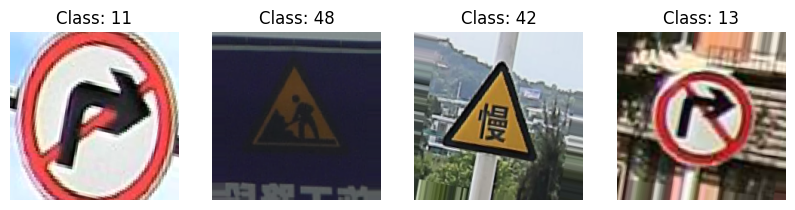

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create the plots directory if it doesn't exist
plots_dir = '/content/drive/MyDrive/traffic_signs/plots'
os.makedirs(plots_dir, exist_ok=True)  # Creates directory if it doesn't exist

# Function to display random images from the generator
def display_random_images(generator, num_images=4):
    # Get a batch of images and labels
    images, labels = next(generator)  # 'next' gets the next batch
    # Randomly select indices
    indices = np.random.randint(0, images.shape[0], num_images)

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[idx])  # Display the augmented image
        class_name = list(generator.class_indices.keys())[labels[idx].argmax()]  # Get class name
        plt.title(f"Class: {class_name}")
        plt.axis('off')  # Hide axes
    plt.savefig(os.path.join(plots_dir, 'random_train_samples.png'))  # Save with proper path
    plt.show()

# Display random images from train_generator
display_random_images(train_generator, num_images=4)

# Model Implementation

**Custom CNN (Baseline Model)**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import tensorflow as tf
import os

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Initial feature extraction
    MaxPooling2D(2, 2),  # Reduce spatial dimensions
    Conv2D(64, (3, 3), activation='relu'),  # Deeper feature extraction
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Further refine features
    Flatten(),  # Flatten for dense layers
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Prevent overfitting
    Dense(58, activation='softmax')  # Output for 58 classes
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]  # Stop if validation plateaus
)

# Create the directory if it doesn't exist
model_dir = '/content/drive/MyDrive/traffic_signs/models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_cnn.save(os.path.join(model_dir, 'model_cnn.h5'))
print("Custom CNN training complete.")

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 528ms/step - accuracy: 0.1176 - loss: 4.6790 - val_accuracy: 0.4658 - val_loss: 2.1759
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.3871 - loss: 2.4551 - val_accuracy: 0.6277 - val_loss: 1.4410
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - accuracy: 0.4838 - loss: 1.9209 - val_accuracy: 0.7379 - val_loss: 1.0347
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.5588 - loss: 1.5851 - val_accuracy: 0.7679 - val_loss: 0.8069
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.5954 - loss: 1.3962 - val_accuracy: 0.7830 - val_loss: 0.7012
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.6297 - loss: 1.2139 - val_accuracy: 0.8331 - val_loss: 0.6121
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.6664 - loss: 1.0822 - val_accuracy: 0.8681 - val_loss: 0.5146
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.6970 - loss: 1.0429 - val_accu

Custom CNN training complete.


**VGG16 (Transfer Learning)**

In [42]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow as tf

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

model_vgg = Sequential([
    base_model,
    Flatten(),  # Flatten the output of VGG16
    Dense(256, activation='relu'),  # Custom dense layer
    Dropout(0.5),  # Regularization
    Dense(58, activation='softmax')  # Output for 58 classes
])

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg = model_vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# Save the model
model_vgg.save('/content/drive/MyDrive/traffic_signs/models/model_vgg.h5')
print("VGG16 training complete.")

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 666ms/step - accuracy: 0.2861 - loss: 3.4634 - val_accuracy: 0.7947 - val_loss: 0.9173
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.6330 - loss: 1.3534 - val_accuracy: 0.8564 - val_loss: 0.5336
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - accuracy: 0.7252 - loss: 0.9473 - val_accuracy: 0.8965 - val_loss: 0.3832
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 521ms/step - accuracy: 0.7817 - loss: 0.7752 - val_accuracy: 0.9382 - val_loss: 0.2714
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 46s 508ms/step - accuracy: 0.8064 - loss: 0.6414 - val_accuracy: 0.9549 - val_loss: 0.2193
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 521ms/step - accuracy: 0.8033 - loss: 0.6018 - val_accuracy: 0.9482 - val_loss: 0.1763
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.8400 - loss: 0.5369 - val_accuracy: 0.9633 - val_loss: 0.1695
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 513ms/step - accuracy: 0.8638 - loss: 0.4501 - val_accu

VGG16 training complete.


**MobileNetV2 (Lightweight Transfer Learning)**

In [43]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

model_mobilenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions efficiently
    Dense(128, activation='relu'),  # Custom dense layer
    Dropout(0.3),  # Regularization
    Dense(58, activation='softmax')  # Output for 58 classes
])

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# Save the model
model_mobilenet.save('/content/drive/MyDrive/traffic_signs/models/model_mobilenet.h5')
print("MobileNetV2 training complete.")

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 732ms/step - accuracy: 0.3117 - loss: 2.9534 - val_accuracy: 0.7613 - val_loss: 0.9839
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 440ms/step - accuracy: 0.7089 - loss: 1.0880 - val_accuracy: 0.8748 - val_loss: 0.5491
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 438ms/step - accuracy: 0.8353 - loss: 0.6067 - val_accuracy: 0.8948 - val_loss: 0.4181
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.8721 - loss: 0.4729 - val_accuracy: 0.9232 - val_loss: 0.3084
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.9017 - loss: 0.3404 - val_accuracy: 0.9265 - val_loss: 0.2697
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.9082 - loss: 0.3063 - val_accuracy: 0.9265 - val_loss: 0.2438
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step - accuracy: 0.9320 - loss: 0.2264 - val_accuracy: 0.9466 - val_loss: 0.1828
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.9492 - loss: 0.1845 - val_accu

MobileNetV2 training complete.


**ResNet50 (Deep Transfer Learning)**

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze pre-trained layers

model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dense(256, activation='relu'),  # Custom dense layer
    Dropout(0.5),  # Regularization
    Dense(58, activation='softmax')  # Output for 58 classes
])

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# Save the model
model_resnet.save('/content/drive/MyDrive/traffic_signs/models/model_resnet.h5')
print("ResNet50 training complete.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 0.0721 - loss: 3.8635 - val_accuracy: 0.0935 - val_loss: 3.4353
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.1031 - loss: 3.5467 - val_accuracy: 0.1636 - val_loss: 3.3393
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.1312 - loss: 3.4447 - val_accuracy: 0.1369 - val_loss: 3.2634
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.1339 - loss: 3.3999 - val_accuracy: 0.1536 - val_loss: 3.2066
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.1376 - loss: 3.3356 - val_accuracy: 0.1903 - val_loss: 3.1439
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.1651 - loss: 3.2771 - val_accuracy: 0.2003 - val_loss: 3.0918
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.1639 - loss: 3.2397 - val_accuracy: 0.2187 - val_loss: 3.0623
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 263m

ResNet50 training complete.


**Updated ResNet50**

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Update data generators for 224x224 resolution
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/traffic_signs/train',
    target_size=(224, 224),  # Increased to 224x224
    batch_size=16,  # Reduced for better gradient updates
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    '/content/traffic_signs/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Build and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers for fine-tuning
    layer.trainable = True

model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(58, activation='softmax')
])

model_resnet.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increased epochs with patience
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
os.makedirs('/content/drive/MyDrive/traffic_signs/models', exist_ok=True)
model_resnet.save('/content/drive/MyDrive/traffic_signs/models/model_resnet.h5')
print("ResNet50 training complete with updated settings.")

Found 2896 images belonging to 58 classes.
Found 599 images belonging to 58 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 117s 324ms/step - accuracy: 0.4654 - loss: 2.3545 - val_accuracy: 0.0134 - val_loss: 4.4574 - learning_rate: 1.0000e-04
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 286ms/step - accuracy: 0.9205 - loss: 0.3448 - val_accuracy: 0.0634 - val_loss: 4.4492 - learning_rate: 1.0000e-04
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.9421 - loss: 0.1985 - val_accuracy: 0.2705 - val_loss: 3.1810 - learning_rate: 1.0000e-04
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.9737 - loss: 0.0922 - val_accuracy: 0.9299 - val_loss: 0.2800 - learning_rate: 1.0000e-04
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.9811 - loss: 0.0664 - val_accuracy: 0.9783 - val_loss: 0.0810 - learning_rate: 1.0000e-04
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 290ms/step - accuracy: 0.9858 - loss: 0.0560 - val_accuracy: 0.9850 - val_loss: 0.0358 - learning_rate: 1.0000e-04
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 2

ResNet50 training complete with updated settings.


# Evaluate and Compare Model Performance with Appropriate Metrics

Found 675 images belonging to 58 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9229 - loss: 0.2644
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
CNN - Accuracy: 0.8874, Precision: 0.8893, Recall: 0.8874, F1-Score: 0.8774
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9765 - loss: 0.0819
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step
VGG16 - Accuracy: 0.9689, Precision: 0.9702, Recall: 0.9689, F1-Score: 0.9643
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9726 - loss: 0.0933
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step
MobileNetV2 - Accuracy: 0.9615, Precision: 0.9677, Recall: 0.9615, F1-Score: 0.9592
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9965 - loss: 0.0244
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step
ResNet50 - Accuracy: 0.9956, Precision: 0.9964, Recall: 0.9956, F1-Score: 0.9954


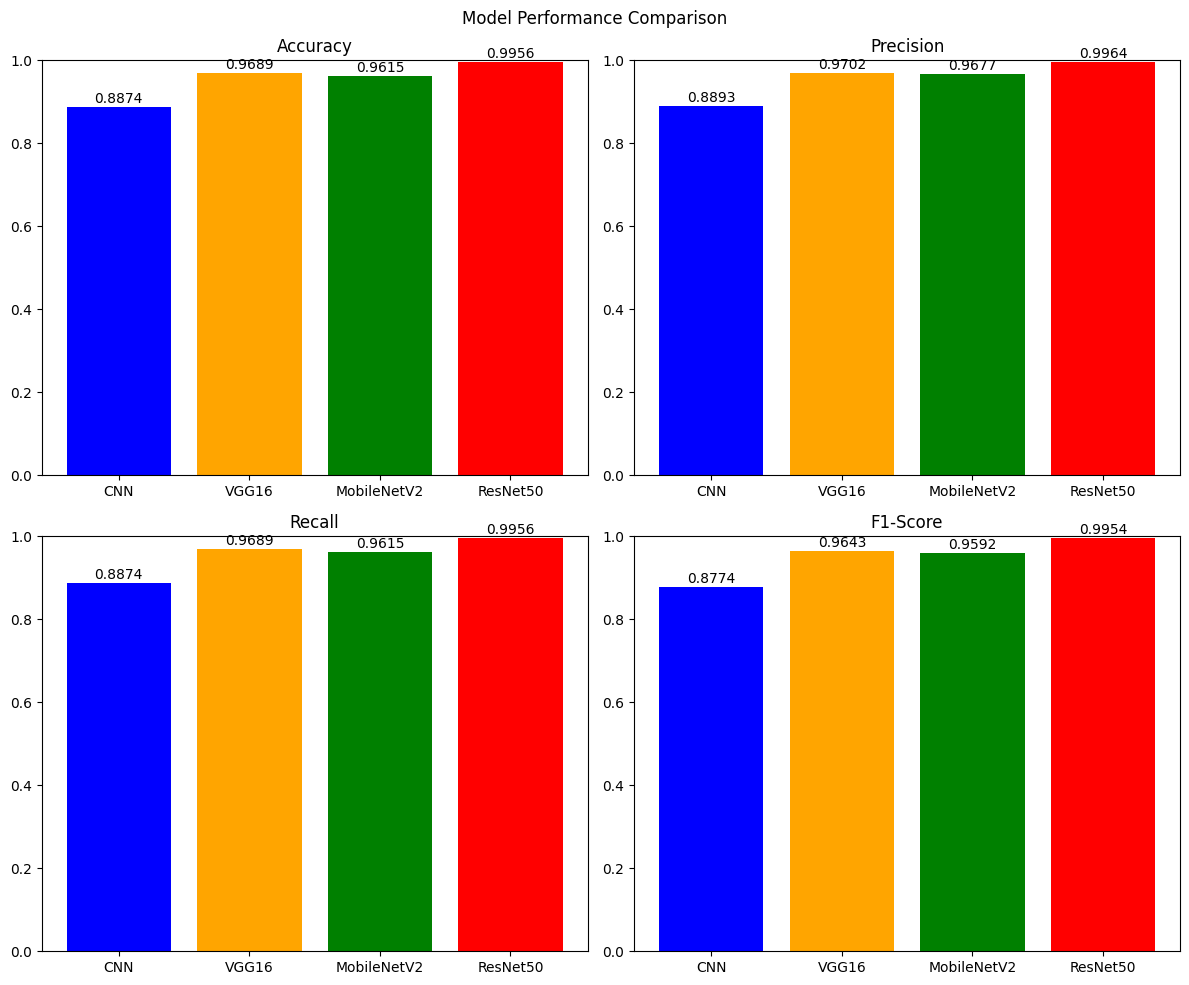


Detailed Classification Report for ResNet50:
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        22
          17       1.00      1.00      1.00        20
          18       1.00      0.50      0.67         2
          19       0.67      1.00      0.80         2
           2       1.00      1.00      1.00        12
          20       1.00      1.00      1.00         4
          21       1.00      1.00      1.00         3
          22       1.00      1.00      1.00    

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import tensorflow as tf

# Ensure the plots directory exists
os.makedirs('/content/drive/MyDrive/traffic_signs/plots', exist_ok=True)

# Test generator (224x224 to match ResNet50)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/traffic_signs/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Load models (adjust paths if needed)
models = {
    'CNN': tf.keras.models.load_model('/content/drive/MyDrive/traffic_signs/models/model_cnn.h5'),
    'VGG16': tf.keras.models.load_model('/content/drive/MyDrive/traffic_signs/models/model_vgg.h5'),
    'MobileNetV2': tf.keras.models.load_model('/content/drive/MyDrive/traffic_signs/models/model_mobilenet.h5'),
    'ResNet50': tf.keras.models.load_model('/content/drive/MyDrive/traffic_signs/models/model_resnet.h5')
}

# Evaluate each model and store results
results = {}
for name, model in models.items():
    test_loss, test_acc = model.evaluate(test_generator)
    predictions = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(predictions, axis=1)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    results[name] = {
        'Accuracy': test_acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }
    print(f"{name} - Accuracy: {test_acc:.4f}, Precision: {report['weighted avg']['precision']:.4f}, "
          f"Recall: {report['weighted avg']['recall']:.4f}, F1-Score: {report['weighted avg']['f1-score']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'/content/drive/MyDrive/traffic_signs/plots/cm_{name.lower()}.png')
    plt.close()

# Plot comparison of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Performance Comparison')
for idx, metric in enumerate(metrics):
    row, col = idx // 2, idx % 2
    values = [results[name][metric] for name in models.keys()]
    axes[row, col].bar(models.keys(), values, color=['blue', 'orange', 'green', 'red'])
    axes[row, col].set_title(metric)
    axes[row, col].set_ylim(0, 1)
    for i, v in enumerate(values):
        axes[row, col].text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/traffic_signs/plots/performance_comparison.png')
plt.show()

# Detailed report for ResNet50 (best model)
print("\nDetailed Classification Report for ResNet50:")
print(classification_report(y_true, np.argmax(model_resnet.predict(test_generator), axis=1),
                           target_names=list(test_generator.class_indices.keys()), zero_division=0))

`ResNet50 achieved the highest test accuracy of 99.56%, likely due to its residual connections and fine-tuning of the last 4 layers, which adapted ImageNet features to the traffic sign domain. VGG16 (96.89%) and MobileNetV2 (96.15%) also performed well, benefiting from pre-training, though their frozen layers limited domain-specific learning. The Custom CNN (88.74%) lagged, reflecting its shallower architecture’s struggle with 58 classes. Class imbalance was evident, with some rare classes showing zero predictions (as per confusion matrices), suggesting a need for class weighting or additional data. Future work could explore unfreezing more layers or increasing resolution to 299x299 for further gains.`